For development and testing of the Module SlowSumOfBumpFcns

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import generate_hypergrid_pts
from janelia_core.ml.generation import BumpFcnGenerator
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.wandering_modules import SlowSumOfBumpFcns

## Parameters go here

In [3]:
n_dims = 3
n_smps = 10000

## Helper functions go here

In [4]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100, dims=[0, 1], fixed_values=None):
    
    pts = generate_hypergrid_pts(d = 2, n_smps_per_dim=n_smps_per_dim)

    if fixed_values is None:
        full_pts = np.zeros([pts.shape[0], n_dims])
    else:
        full_pts = np.tile(np.expand_dims(fixed_values, 1), pts.shape[0]).transpose()
    
    
    full_pts[:, dims[0]] = pts[:,0]
    full_pts[:, dims[1]] = pts[:, 1]
    
    y_grid = f(full_pts).reshape([n_smps_per_dim, n_smps_per_dim])
    plt.imshow(y_grid)
    plt.colorbar()

In [5]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None,
        update_int=100):

    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.pert_grads()
        optimizer.step()
        nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
            #print('c: ' + str(nn.c))
            #print('w: ' + str(nn.w))
           # print('m: ' + str(nn.m))

## Generate the true function and data

In [6]:
run_on_gpu = False

In [12]:
fcn_generator = BumpFcnGenerator(n_bumps = 20, d=n_dims, bump_peak_vl_range = [-1, 1], cov_ev_range = [.01, .01])
f_true = fcn_generator.generate()

x = np.random.rand(10000,n_dims)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [13]:
n_fit_bumps = 20
f_fit = SlowSumOfBumpFcns(c=torch.rand([n_dims, n_fit_bumps]), w=5*torch.ones([n_dims, n_fit_bumps]),
                      m=torch.zeros(n_fit_bumps),
                      c_bounds=torch.stack((torch.zeros(n_dims), torch.ones(n_dims))).t(),
                      w_bounds=torch.stack((.01*torch.ones(n_dims), 10*torch.ones(n_dims))).t())

In [14]:
if run_on_gpu:
    f_fit.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    f_fit.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [15]:
t_0 = time.time()

for i in range(1):
    fit(nn=f_fit, x=x, y=y, lr=.01, n_its=10001, batch_size=1000, update_int=100)

    t_stop = time.time()
print('Elapsed time: ' + str(t_stop - t_0))

It 0: 1.276790e-02
It 100: 1.125549e-02
It 200: 1.089680e-02
It 300: 9.333414e-03
It 400: 1.460997e-02
It 500: 1.044147e-02
It 600: 9.331492e-03
It 700: 9.192124e-03
It 800: 8.935797e-03
It 900: 7.291079e-03
It 1000: 1.011295e-02
It 1100: 8.087748e-03
It 1200: 9.248402e-03
It 1300: 7.827464e-03
It 1400: 7.610392e-03
It 1500: 6.876748e-03
It 1600: 7.690521e-03
It 1700: 5.076614e-03
It 1800: 4.115495e-03
It 1900: 4.799561e-03
It 2000: 4.756849e-03
It 2100: 4.331010e-03
It 2200: 4.837640e-03
It 2300: 3.120139e-03
It 2400: 3.234938e-03
It 2500: 3.081861e-03
It 2600: 2.649565e-03
It 2700: 2.031678e-03
It 2800: 1.914372e-03
It 2900: 1.662214e-03
It 3000: 1.982734e-03
It 3100: 1.358041e-03
It 3200: 1.042919e-03
It 3300: 9.628438e-04
It 3400: 8.196310e-04
It 3500: 8.404148e-04
It 3600: 9.671632e-04
It 3700: 7.346905e-04
It 3800: 5.386748e-04
It 3900: 4.572998e-04
It 4000: 5.577200e-04
It 4100: 4.029323e-04
It 4200: 5.490242e-04
It 4300: 6.255953e-04
It 4400: 5.467294e-04
It 4500: 5.803959e-04


In [16]:
f_fit.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

## View the true and fit functions

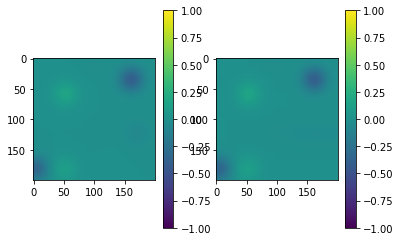

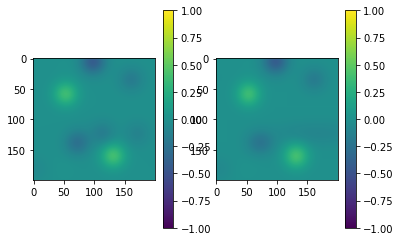

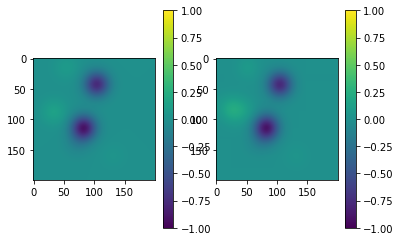

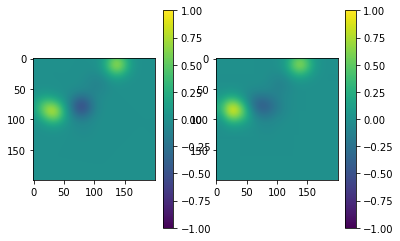

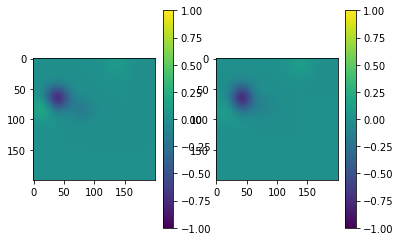

In [17]:
z_values = np.arange(0, 1, .2)
for z_v in z_values:
    plt.figure()
    plt.subplot(1,2,1)
    plot_2d_f(f_true, n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])
    plt.subplot(1,2,2)
    plot_2d_f(torch_mod_to_fcn(f_fit), n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.clim([-1, 1])